In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciopt
import qutip as qtp

## Hamiltonian parameters from ibmq_lima Q0 & Q1

In [2]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_lima')

true_params = backend.configuration().hamiltonian['vars']

In [31]:
true_params

{'delta0': -2109526390.232452,
 'delta1': -2000246532.4219205,
 'delta2': -2096093619.9138844,
 'delta3': -2081254439.3432896,
 'delta4': -2101534832.5639515,
 'jq0q1': 11088625.669671271,
 'jq1q2': 11792549.39343634,
 'jq1q3': 11913891.984976945,
 'jq3q4': 11656329.753118027,
 'omegad0': 1593402377.231421,
 'omegad1': 1300785782.5911577,
 'omegad2': 1404903755.9634743,
 'omegad3': 1557937525.9312246,
 'omegad4': 1551571973.5037224,
 'wq0': 31602884665.57153,
 'wq1': 32218200846.588806,
 'wq2': 32970129803.696487,
 'wq3': 33314574775.726036,
 'wq4': 31995032477.852844}

In [3]:
twopi = 2. * np.pi

# In Mrad/s
omega0 = true_params['wq0'] * 1.e-9
omega1 = true_params['wq1'] * 1.e-9
J = true_params['jq0q1'] * 1.e-9
Omega0 = true_params['omegad0'] * 1.e-9 * 0.06 # last factor from the CX pulse schedule
alpha01 = 0.8 # randomly chosen
phi01 = np.pi / 4. # also randomly chosen

delta = omega1 - omega0

## Rotating wave Hamiltonian

Note: $\sigma^+$ annihilates an excitation

Although the Hamiltonian given by `backend.configuration().hamiltonian['description']` is

$$
\begin{align} \mathcal{H}/\hbar = & \sum_{i=0}^{4}\left(\frac{\omega_{q,i}}{2}(\mathbb{I}-\sigma_i^{z})+\frac{\Delta_{i}}{2}(O_i^2-O_i)+\Omega_{d,i}D_i(t)\sigma_i^{X}\right) \\ & + J_{0,1}(\sigma_{0}^{+}\sigma_{1}^{-}+\sigma_{0}^{-}\sigma_{1}^{+}) + J_{1,2}(\sigma_{1}^{+}\sigma_{2}^{-}+\sigma_{1}^{-}\sigma_{2}^{+}) + J_{1,3}(\sigma_{1}^{+}\sigma_{3}^{-}+\sigma_{1}^{-}\sigma_{3}^{+}) + J_{3,4}(\sigma_{3}^{+}\sigma_{4}^{-}+\sigma_{3}^{-}\sigma_{4}^{+}) \\ & + \Omega_{d,0}(U_{0}^{(0,1)}(t))\sigma_{0}^{X} + \Omega_{d,1}(U_{1}^{(1,0)}(t)+U_{3}^{(1,3)}(t)+U_{2}^{(1,2)}(t))\sigma_{1}^{X} \\ & + \Omega_{d,2}(U_{4}^{(2,1)}(t))\sigma_{2}^{X} + \Omega_{d,3}(U_{6}^{(3,4)}(t)+U_{5}^{(3,1)}(t))\sigma_{3}^{X} \\ & + \Omega_{d,4}(U_{7}^{(4,3)}(t))\sigma_{4}^{X}, \\ \end{align}
$$

in practice there are cross-talk terms that should be represented as

$$
H_{\mathrm{ct}}/\hbar = \sum_{j \neq k} \Omega_{d,j} (D_j(t) + \sum_c U_j^c(t)) \alpha_{j,k} [\cos(\phi_{j,k}) \sigma_k^X - \sin(\phi_{j,k}) \sigma_k^Y].
$$

Then for a 0-1 CR drive $\Omega_{d,0} U_0^{(0,1)}(t) = \Omega \cos(\omega_1 t)$, we have

$$
H = -\frac{\omega_0}{2}\sigma^Z_0 -\frac{\omega_1}{2}\sigma^Z_1 + J (\sigma^+_0\sigma^-_1 + \sigma^-_0 \sigma^+_1) + \Omega \cos(\omega_1 t) \left\{ \sigma^X_0 + \alpha_{0,1} [\cos(\phi_{0,1}) \sigma_1^X - \sin(\phi_{0,1}) \sigma_1^Y] \right\} \\
U_{H_0} = \exp \left[ i \left( \frac{\omega_0}{2} \sigma^Z_0 + \frac{\omega_1}{2} \sigma^Z_1 \right) t \right]
$$

$$
\begin{align}
\tilde{H} & = U_{H_0}^{\dagger} H U_{H_0} - i U_{H_0}^{\dagger} \dot{U}_{H_0} \\
& \sim J \exp \left[ -i (\omega_0 \sigma^Z_0 + \omega_1 \sigma^Z_1) t \right] (\sigma^+_0\sigma^-_1 + \sigma^-_0 \sigma^+_1) + \frac{\Omega}{2} \exp \left[ i (\omega_1 - \omega_0) \sigma^Z_0 t \right] \sigma^X_0 \\
& = J (e^{i \delta t} \sigma^+_0\sigma^-_1 + e^{-i \delta t} \sigma^-_0\sigma^+_1) + \frac{\Omega}{2} (e^{i \delta t} \sigma^+_0 + e^{-i \delta t} \sigma^-_0) + \frac{\Omega \alpha_{0, 1}}{2} (e^{i \phi_{0,1}} \sigma^+_1 + e^{-i \phi_{0,1}} \sigma^-_1)
\end{align}
$$

In [4]:
mp = qtp.tensor(qtp.sigmam(), qtp.sigmap())
pm = qtp.tensor(qtp.sigmap(), qtp.sigmam())

Hcross = Omega0 * alpha01 / 2. * qtp.tensor(qtp.qeye(2), np.cos(phi01) * qtp.sigmax() - np.sin(phi01) * qtp.sigmay())
Hcos = J * (pm + mp) + Omega0 / 2. * qtp.tensor(qtp.sigmax(), qtp.qeye(2))
Hsin = 1.j * J * (pm - mp) - Omega0 / 2. * qtp.tensor(qtp.sigmay(), qtp.qeye(2))

hamiltonian = [Hcross, (Hcos, f'cos({delta} * t)'), (Hsin, f'sin({delta} * t)')]

## Validation with no crosstalk term

In [5]:
# Time evolution for 10000 cycles, ~10 time points per cycle
tlist = np.linspace(0., twopi / omega1 * 1000, 10000)

e_ops = []
paulis = [qtp.qeye(2), qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]
for p0 in paulis:
    for p1 in paulis:
        e_ops.append(qtp.tensor(p0, p1))
        
psi0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # Initial state |00>
result_0 = qtp.sesolve(hamiltonian[1:], psi0, tlist, e_ops=e_ops)

psi0 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # Initial state |10>
result_1 = qtp.sesolve(hamiltonian[1:], psi0, tlist, e_ops=e_ops)

obs_0 = {}
obs_1 = {}
for p0 in 'ixyz':
    for p1 in 'ixyz':
        exp_0 = result_0.expect[len(obs_0)]
        exp_1 = result_1.expect[len(obs_1)]
        obs_0[p0 + p1] = exp_0
        obs_1[p0 + p1] = exp_1

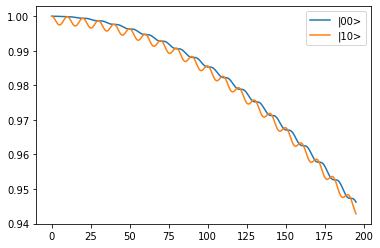

In [6]:
plt.plot(tlist, obs_0['iz'], label='|00>')
plt.plot(tlist, obs_1['iz'], label='|10>')
plt.legend()

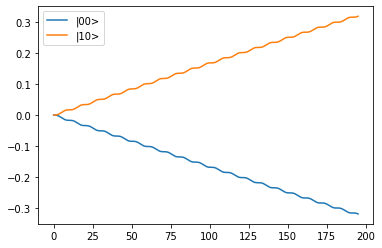

In [7]:
plt.plot(tlist, obs_0['iy'], label='|00>')
plt.plot(tlist, obs_1['iy'], label='|10>')
plt.legend()

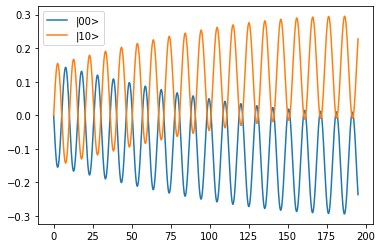

In [8]:
plt.plot(tlist, obs_0['yi'], label='|00>')
plt.plot(tlist, obs_1['yi'], label='|10>')
plt.legend()

## Effective Hamiltonian

In [9]:
# Evolve the identity matrix for ~1000 cycles, 10 time points per cycle
tlist = np.linspace(0., twopi / omega1 * 1000, 10000)
psi0 = qtp.tensor(qtp.qeye(2), qtp.qeye(2))

result = qtp.sesolve(hamiltonian, psi0, tlist)
unitaries = np.concatenate(list(np.expand_dims(state.full(), axis=0) for state in result.states))

In [10]:
eigvals, eigcols = np.linalg.eig(unitaries)
eigrows = np.conjugate(np.transpose(eigcols, axes=(0, 2, 1)))
#diagonal = eigrows @ unitaries @ eigcols # numerical precision ~1.e-6

In [11]:
#Heff_t = eigcols @ (-np.angle(diagonal)) @ eigrows
omega_t = -np.angle(eigvals)
Heff_t = (eigcols * np.tile(np.expand_dims(omega_t, axis=1), (1, 4, 1))) @ eigrows

itmax = 3500
indices = np.argsort(omega_t, axis=1)
omega_t = np.take_along_axis(omega_t, indices, axis=1)
eigcols = eigcols[(np.tile(np.expand_dims(np.arange(omega_t.shape[0]), axis=-1), (1, omega_t.shape[1])), indices)]

energies = np.empty(omega_t.shape[1])
for ie in range(omega_t.shape[1]):
    energies[ie] = sciopt.curve_fit(lambda t, a: a * t, tlist[:itmax], omega_t[:itmax, ie])[0]
    
omega_t_linear = np.outer(tlist, energies)

eigrows = np.conjugate(np.transpose(eigcols, axes=(0, 2, 1)))
Heff_t = (eigcols * np.tile(np.expand_dims(omega_t_linear, axis=1), (1, 4, 1))) @ eigrows

In [12]:
paulis = [(qtp.qeye(2), 'i'), (qtp.sigmax(), 'x'), (qtp.sigmay(), 'y'), (qtp.sigmaz(), 'z')]
pauli_basis = {}

for p0, l0 in paulis:
    for p1, l1 in paulis:
        pauli_basis[l0 + l1] = qtp.tensor(p0, p1).full() / 2.

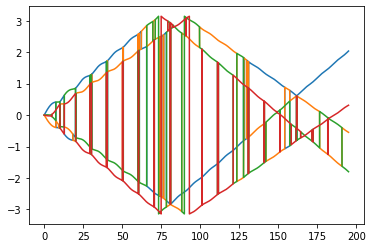

In [29]:
plt.plot(tlist, omega_t)

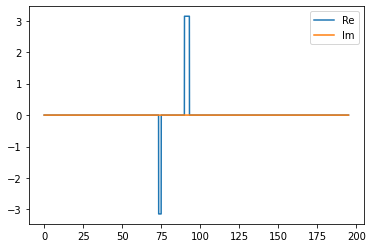

In [13]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['ii'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['ii'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

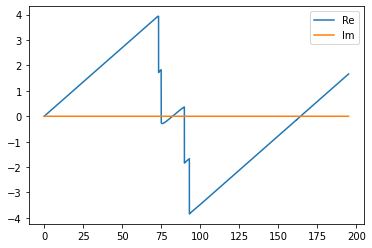

In [14]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['ix'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['ix'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

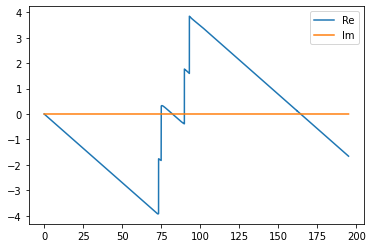

In [15]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['iy'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['iy'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

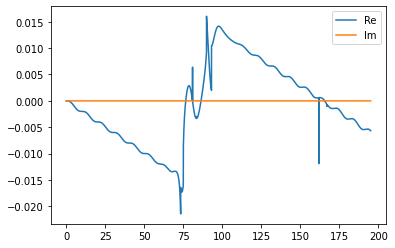

In [16]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['iz'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['iz'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

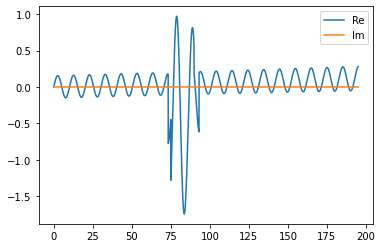

In [17]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xi'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xi'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

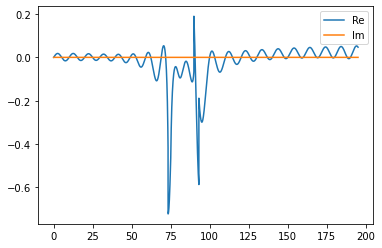

In [18]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xx'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xx'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

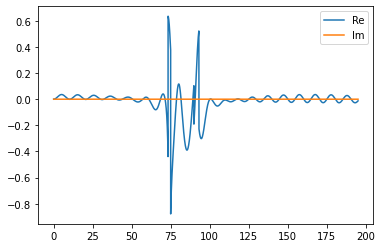

In [19]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xy'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xy'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

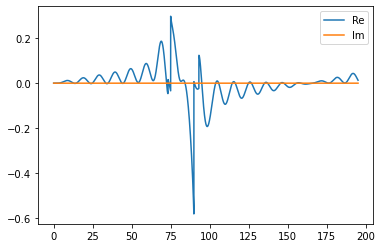

In [20]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xz'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['xz'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

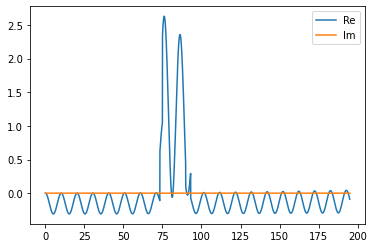

In [21]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yi'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yi'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

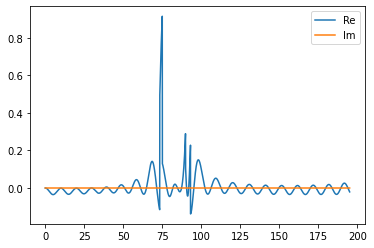

In [22]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yx'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yx'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

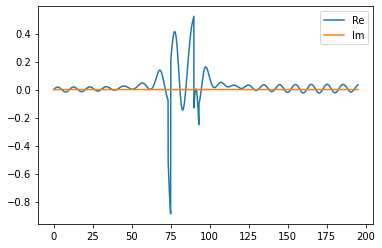

In [23]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yy'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yy'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

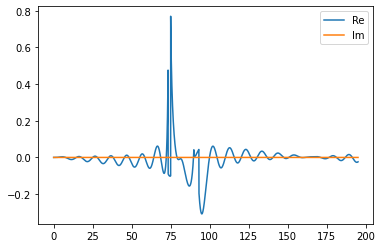

In [24]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yz'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['yz'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

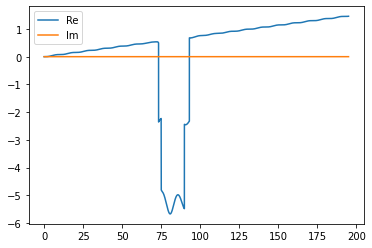

In [25]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zi'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zi'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

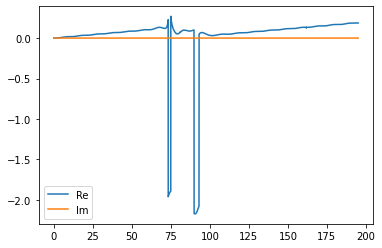

In [26]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zx'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zx'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

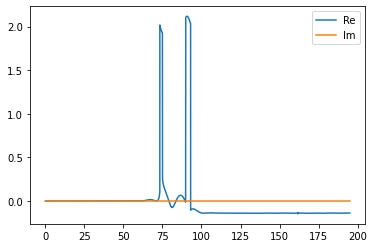

In [27]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zy'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zy'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

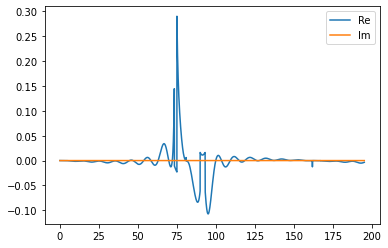

In [28]:
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zz'], axis1=1, axis2=2).real, label='Re')
plt.plot(tlist, np.trace(Heff_t @ pauli_basis['zz'], axis1=1, axis2=2).imag, label='Im')
plt.legend()

## Observations

* Imaginary parts of the Pauli traces are identically zero, as they should be.
* Individual Pauli components behave stably up to the first $2\pi$ jump of the eigenvalues. The eigenvalues themselves can switch orders randomly.

## Strategy

* Sort the eigenvalues by value and find the first t where the maximum/minimum reaches $\pm \pi$.
* Compute the Pauli traces and fit the real part with a line.